In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

In [2]:
data = pd.read_csv("data.csv",usecols=['number_people','date'],index_col=['date'],parse_dates=True,infer_datetime_format=True)

In [3]:
data.head()

,number_people
date,
2015-08-15 00:00:11,37
2015-08-15 00:20:14,45
2015-08-15 00:30:15,40
2015-08-15 00:40:16,44
2015-08-15 00:50:17,45


###### Resample the Data to get Hourly Frequency

In [4]:
#resample the data for an hourly frequency
data2 = data.resample('H').mean()
data2.number_people = data2.number_people.round()
data2.fillna(value=0,inplace=True) # data is not recorded from 8 am to 12 pm

In [5]:
data2.head()

,number_people
date,
2015-08-15 00:00:00,42.0
2015-08-15 01:00:00,48.0
2015-08-15 02:00:00,40.0
2015-08-15 03:00:00,40.0
2015-08-15 04:00:00,45.0


In [6]:
data2.info(null_counts=True,verbose=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13971 entries, 2015-08-15 00:00:00 to 2017-03-19 02:00:00
Freq: H
Data columns (total 1 columns):
number_people    13971 non-null float64
dtypes: float64(1)
memory usage: 218.3 KB


###### Graphically Showing the difference between hourly and '10 min' frequency

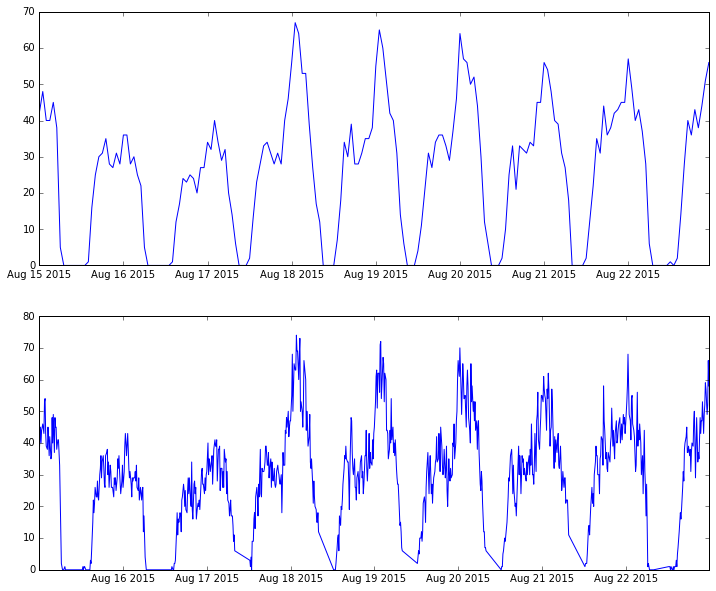

In [7]:
fig1 = plt.figure(figsize=(12,10))
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)
ax1.plot(data2['2015-08-15':'2015-08-22'])
ax2.plot(data['2015-08-15':'2015-08-22'])

###### comparing datq for different years

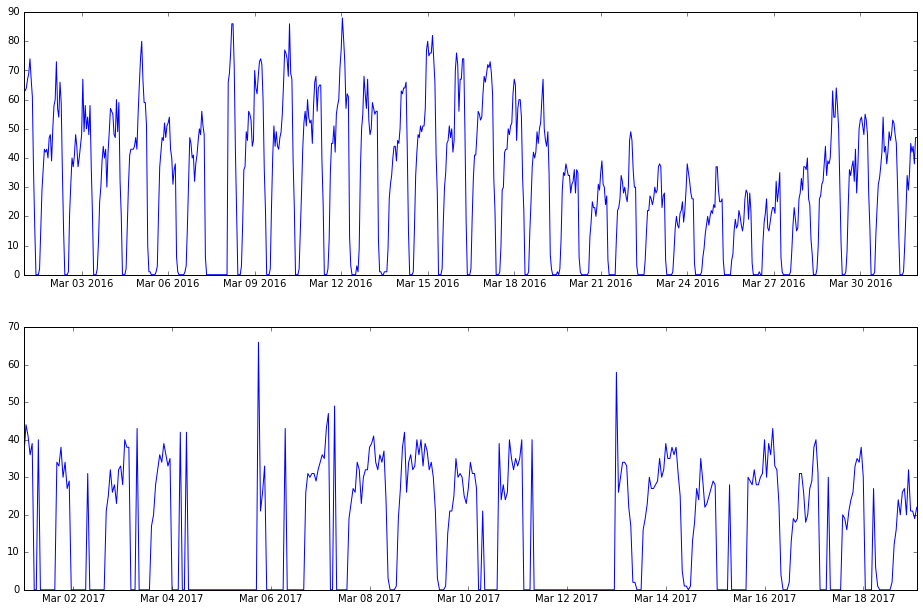

In [8]:
fig = plt.figure(figsize=(16,16))
#ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
#ax1.plot(data2['2015-08-15':'2015-08-22'])
ax2.plot(data2['2016-03'])
ax3.plot(data2['2017-03'])

###### it is better to use the data only for year 2016 for analysis, as data for 2015 and 2017 is irregular

In [25]:
ts = data2['2016']
print ts.head()
print ts.shape

                     number_people
date                              
2016-01-01 00:00:00           30.0
2016-01-01 01:00:00           32.0
2016-01-01 02:00:00           29.0
2016-01-01 03:00:00            5.0
2016-01-01 04:00:00            0.0
(8784, 1)


In [10]:
ts.to_csv('2016',index=False)

###### Time Series Analysis

In [26]:
ts.head()

,number_people
date,
2016-01-01 00:00:00,30.0
2016-01-01 01:00:00,32.0
2016-01-01 02:00:00,29.0
2016-01-01 03:00:00,5.0
2016-01-01 04:00:00,0.0


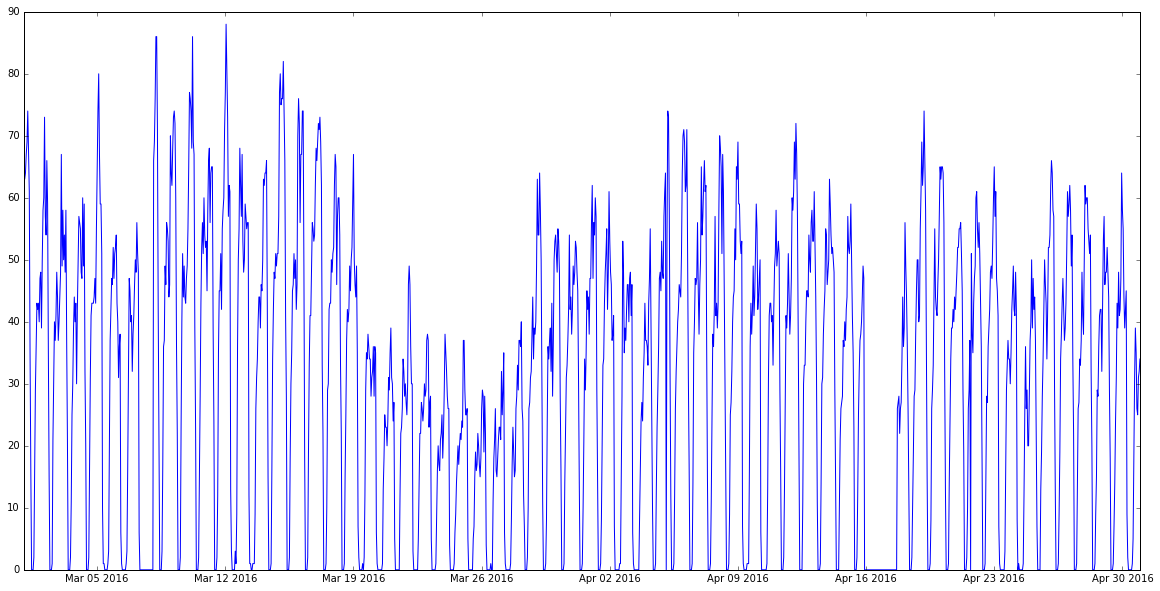

In [70]:
plt.figure(figsize=(20,10))
plt.plot(ts['2016-03':'2016-04'])

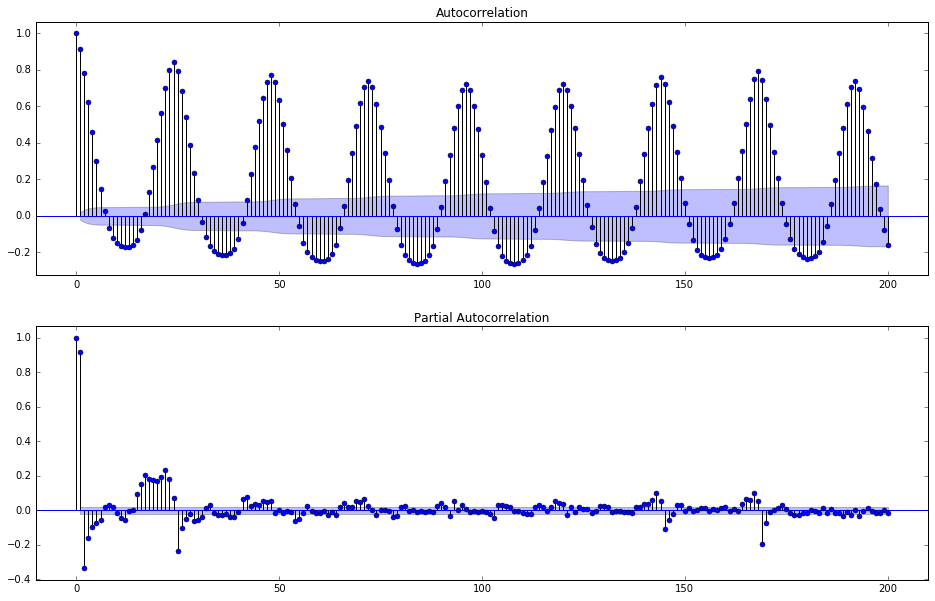

In [27]:
# Plotting ACF and PACF
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts,ax=ax1,lags=200)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts,ax=ax2,lags=200)

In [33]:
ts_diff = ts.diff(periods=1)

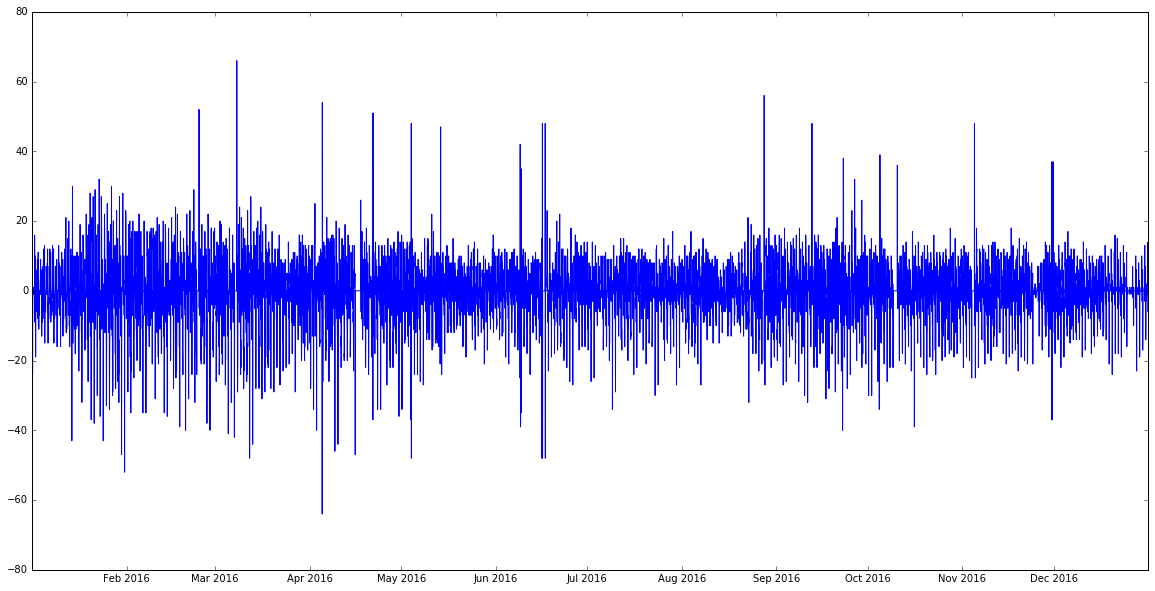

In [59]:
plt.figure(figsize=(20,10))
plt.plot(ts_diff)

In [15]:
#Let us fit an arma(2,0) model
arma_20 = sm.tsa.ARMA(ts,(2,0)).fit()
print arma_20.params
print arma_20.aic

const                 -0.004685
ar.L1.number_people    1.221217
ar.L2.number_people   -0.335250
dtype: float64
60762.929149


In [16]:
# arma(2,1)
arma_21 = sm.tsa.ARMA(ts,(2,1)).fit()
print arma_21.params
print arma_21.aic 
print arma_21.arroots 

const                  0.002256
ar.L1.number_people    1.683305
ar.L2.number_people   -0.757448
ma.L1.number_people   -0.545236
dtype: float64
60402.4571672
[ 1.11116827-0.29245049j  1.11116827+0.29245049j]


In [17]:
#arma(3,2)
arma_32 = sm.tsa.ARMA(ts,(3,2)).fit()
print arma_32.params
print arma_32.aic 
print arma_32.arroots 

const                  0.038964
ar.L1.number_people    2.849525
ar.L2.number_people   -2.772478
ar.L3.number_people    0.918500
ma.L1.number_people   -1.922269
ma.L2.number_people    0.964311
dtype: float64
59581.164344
[ 0.97412457-0.26146514j  0.97412457+0.26146514j  1.07023490-0.j        ]


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


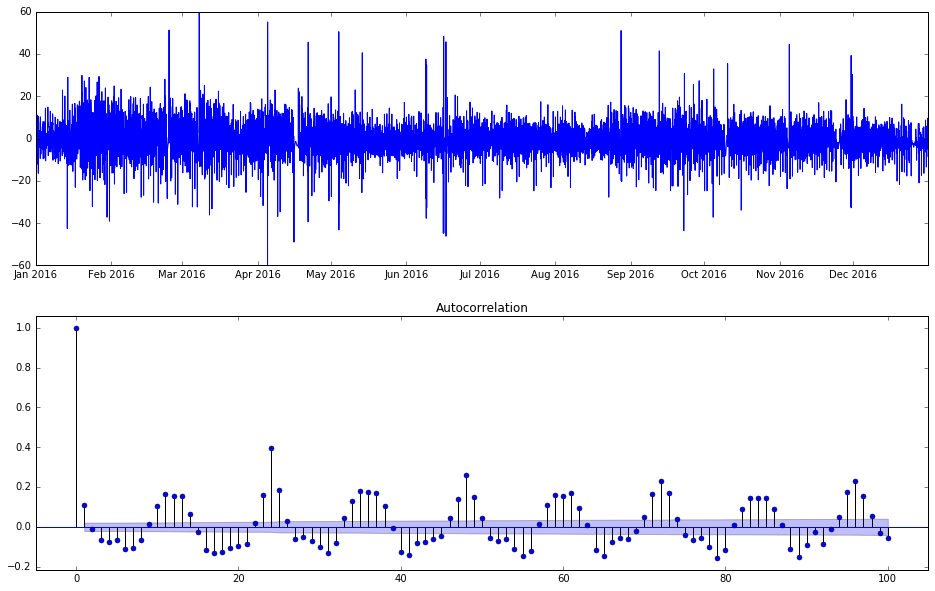

In [18]:
#plotting the residuals for arma(3,2)
residuals = arma_32.resid
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(residuals)
fig = sm.graphics.tsa.plot_acf(residuals,ax=ax2,lags=100)

In [19]:
print arma_32.arroots
print arma_32.params

[ 0.97412457-0.26146514j  0.97412457+0.26146514j  1.07023490-0.j        ]
const                  0.038964
ar.L1.number_people    2.849525
ar.L2.number_people   -2.772478
ar.L3.number_people    0.918500
ma.L1.number_people   -1.922269
ma.L2.number_people    0.964311
dtype: float64


###### Let us also include  the seasonality of period 24 in the model as the above ACF of residuals are correlated

In [83]:
sarimax = sm.tsa.SARIMAX(ts,order=(1,0,0),seasonal_order=(1,1,1,24)).fit()

In [ ]:
# using the procedure outlined in the book

In [91]:
for i in range(5,11):
    try:
        arima = sm.tsa.ARIMA(ts,order=(i,0,i-1)).fit()
        print 'order...' + str(i) + str(i-1)
        print arima.aic
    except:
        print 'order...' + str(i) + str(i-1) + 'unsucessfull....'

order...54unsucessfull....


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order...65
59267.6647459


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order...76
59216.4058465


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order...87
59129.9383218


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order...98
59165.86553
order...109unsucessfull....


In [92]:
for i in range(11,41):
    try:
        arima = sm.tsa.ARIMA(ts,order=(i,0,i-1),).fit()
        print 'order...' + str(i) + str(i-1), arima.aic
    except:
        print 'order...' + str(i) + str(i-1) + 'unsucessfull....'

order...1110unsucessfull....


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order...1211 57549.2889198


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order...1312 57533.238533


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order...1413 57410.3439081


/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


order...1514 57100.5448251
order...1615unsucessfull....
order...1716unsucessfull....
order...1817unsucessfull....
order...1918unsucessfull....
order...2019unsucessfull....
order...2120unsucessfull....
order...2221unsucessfull....
order...2322unsucessfull....
order...2423unsucessfull....
order...2524unsucessfull....
order...2625unsucessfull....
order...2726unsucessfull....
order...2827unsucessfull....
order...2928unsucessfull....
order...3029unsucessfull....
order...3130unsucessfull....
order...3231unsucessfull....
order...3332unsucessfull....
order...3433unsucessfull....
order...3534unsucessfull....
order...3635unsucessfull....
order...3736unsucessfull....
order...3837unsucessfull....
order...3938unsucessfull....
order...4039unsucessfull....


In [93]:
arima = sm.tsa.ARIMA(ts,order=(15,0,14)).fit()
arima.summary()

/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:          number_people   No. Observations:                 8784
Model:                   ARMA(15, 14)   Log Likelihood              -28519.272
Method:                       css-mle   S.D. of innovations              6.213
Date:                Thu, 27 Apr 2017   AIC                          57100.545
Time:                        14:56:21   BIC                          57320.046
Sample:                    01-01-2016   HQIC                         57175.326
                         - 12-31-2016                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   24.2027      0.573     42.231      0.000      23.079      25.326
ar.L1.number_people      2.3019      0.000   1.65e+04      0.000       2.302       2.302
ar.L2.number_people     -2.1887      0.001  -4043.733      0.000      -2.190      -2.188
ar.L3.number_people      0.9095      0.001   1075.337      0.000       0.908       0.911
ar.L4.number_people      0.3151        nan        nan        nan         nan         nan
ar.L5.number_people     -0.5515        nan        nan        nan         nan         nan
ar.L6.number_people      0.0983        nan        nan        nan         nan         nan
ar.L7.number_people     -0.0431        nan        nan        nan         nan         nan
ar.L8.number_people     -0.0901        nan        nan        nan         nan         nan
ar.L9.number_people      0.3456      0.000   2996.315      0.000       0.345       0.346
ar.L10.number_people    -0.2274        nan        nan        nan         nan         nan
ar.L11.number_people     0.3227        nan        nan        nan         nan         nan
ar.L12.number_people    -0.9253        nan        nan        nan         nan         nan
ar.L13.number_people     1.6762        nan        nan        nan         nan         nan
ar.L14.number_people    -1.7879      0.000  -4965.352      0.000      -1.789      -1.787
ar.L15.number_people     0.7602      0.000   2118.835      0.000       0.759       0.761
ma.L1.number_people     -1.4091      0.007   -196.391      0.000      -1.423      -1.395
ma.L2.number_people      0.9114      0.013     67.980      0.000       0.885       0.938
ma.L3.number_people     -0.0535      0.015     -3.609      0.000      -0.083      -0.024
ma.L4.number_people     -0.4260      0.015    -29.258      0.000      -0.455      -0.397
ma.L5.number_people      0.2258      0.015     14.825      0.000       0.196       0.256
ma.L6.number_people      0.0691      0.015      4.759      0.000       0.041       0.098
ma.L7.number_people      0.1229      0.014      8.612      0.000       0.095       0.151
ma.L8.number_people      0.1915      0.015     12.964      0.000       0.163       0.220
ma.L9.number_people     -0.1906      0.015    -12.409      0.000      -0.221      -0.161
ma.L10.number_people     0.1318      0.015      8.566      0.000       0.102       0.162
ma.L11.number_people    -0.2812      0.015    -19.108      0.000      -0.310      -0.252
ma.L12.number_people     0.6453      0.015     43.537      0.000       0.616       0.674
ma.L13.number_people    -0.9500      0.013    -73.756      0.000      -0.975      -0.925
ma.L14.number_people     0.7454      0.008     97.648      0.000       0.730       0.760
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
-------------------------------------------------------------------

In [94]:
print arima.arroots

[-0.96662923-0.25939951j -0.96662923+0.25939951j -0.74322420-0.73899315j
 -0.74322420+0.73899315j -0.26297738-0.99959938j -0.26297738+0.99959938j
  0.25897081-0.96643657j  0.25897081+0.96643657j  0.50082865-0.86728601j
  0.50082865+0.86728601j  0.86692239-0.500427j    0.86692239+0.500427j
  0.96597595-0.25871482j  0.96597595+0.25871482j  1.11226385-0.j        ]


In [95]:
print arima.maroots

[-0.96946026-0.26033624j -0.96946026+0.26033624j -0.75086952-0.75190977j
 -0.75086952+0.75190977j -0.26689618-1.01332517j -0.26689618+1.01332517j
  0.26243917-0.97078934j  0.26243917+0.97078934j  0.50579102-0.87323293j
  0.50579102+0.87323293j  0.97384368-0.25565348j  0.97384368+0.25565348j
  0.88240655-0.4999354j   0.88240655+0.4999354j ]


###### Important points to note(All these factors suggest that model is not accurate.)
1. The variance of the residuals are not constant
2. Residuals are not normally distributed
3. Ljung box statistic is not zero

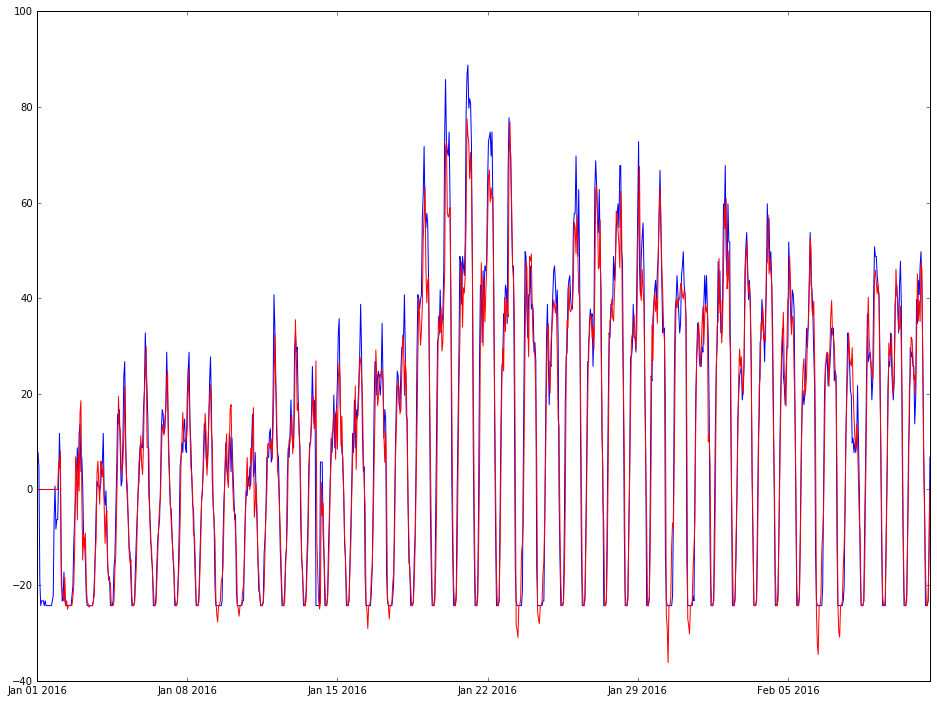

In [24]:
# plot of actual vs fitted values
plt.figure(figsize=(16,12))
plt.plot(ts.index[:1000],ts.values[:1000],'b-',ts.index[:1000],sarimax.fittedvalues[:1000],'r-')

###### We need to weekly seasonality of order P = 168 for further analysis

In [25]:
week_ts = pd.DataFrame({'Day1':ts.number_people['2016-02-01'].values,'Day2':ts.number_people['2016-02-02'].values,
                       'Day3':ts.number_people['2016-02-03'].values,'Day4':ts.number_people['2016-02-04'].values,
                       'Day5':ts.number_people['2016-02-05'].values,'Day6':ts.number_people['2016-02-06'].values,
                       'Day7':ts.number_people['2016-02-07'].values},index=range(0,24))

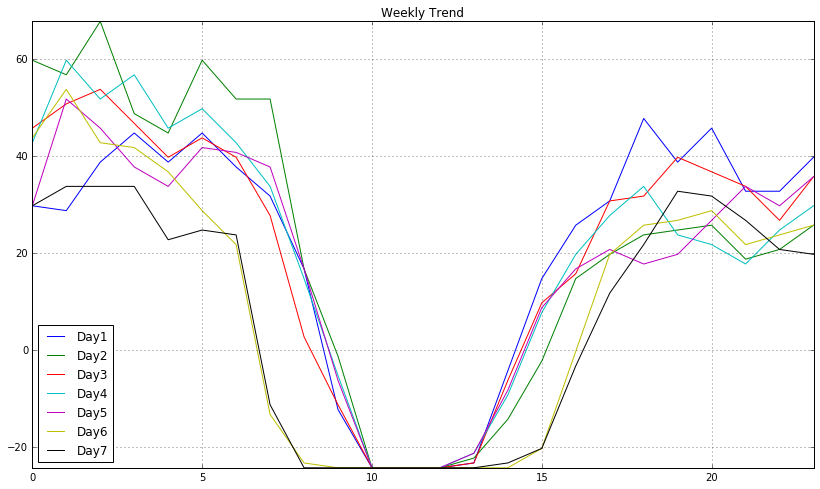

In [26]:
week_ts.plot(figsize=(14,8),title='Weekly Trend',grid=True,ylim=(week_ts.min().min(),week_ts.max().max()))

In [ ]:
# It can be hypothesized by looking at the graph that there is some weekly trend

In [38]:
sarimax = sm.tsa.SARIMAX(ts,order=(1,1,0),seasonal_order=(1,1,1,24)).fit()

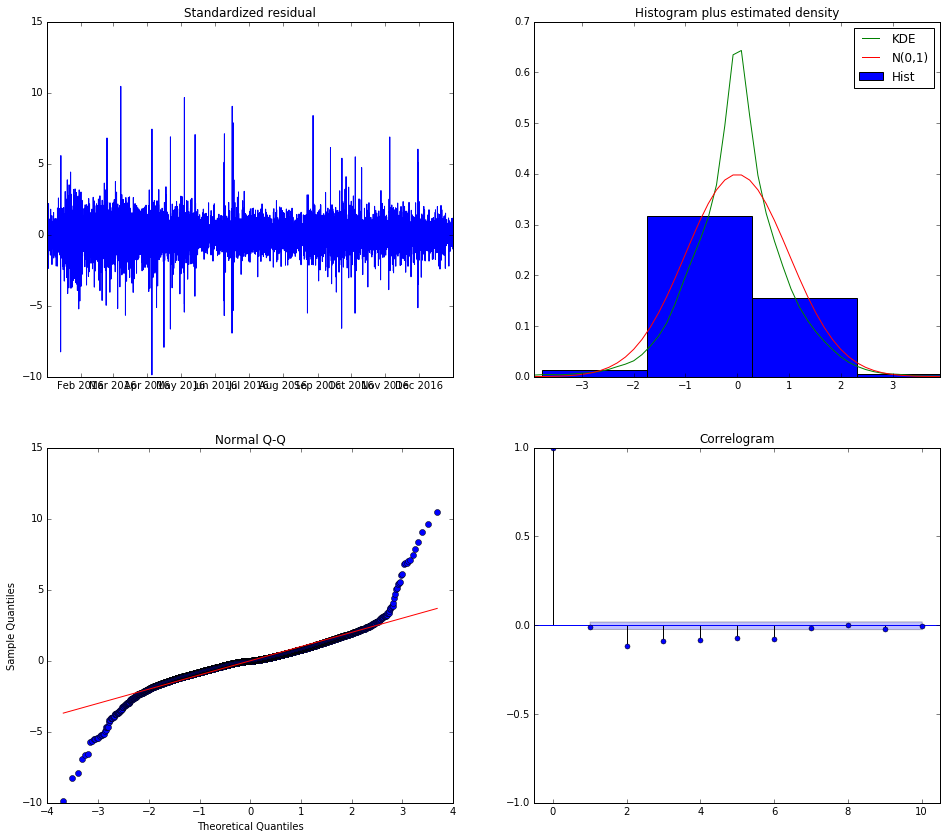

In [41]:
# looking at the plot diagnostics of the residuals
fig = plt.figure(figsize=(16,14))
fig = sarimax.plot_diagnostics(fig=fig)

In [43]:
# Diagnostic Summary
print sarimax.summary()

                                 Statespace Model Results                                 
Dep. Variable:                      number_people   No. Observations:                 8784
Model:             SARIMAX(1, 1, 0)x(1, 1, 1, 24)   Log Likelihood              -28588.398
Date:                            Mon, 24 Apr 2017   AIC                          57184.795
Time:                                    22:58:20   BIC                          57213.118
Sample:                                01-01-2016   HQIC                         57194.444
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0956      0.006    -16.079      0.000      -0.107      -0.084
ar.S.L24       0.1857      0.008   

In [101]:
ts['shift_1'] = ts.shift(1).number_people
ts['shift_2'] = ts.shift(2).number_people
ts['shift_3'] = ts.shift(3).number_people

/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [103]:
ts.dropna(inplace=True)

/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [105]:
ts['y'] = ts.number_people -2.93*ts.shift_1+2.93*ts.shift_2- ts.shift_3

/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


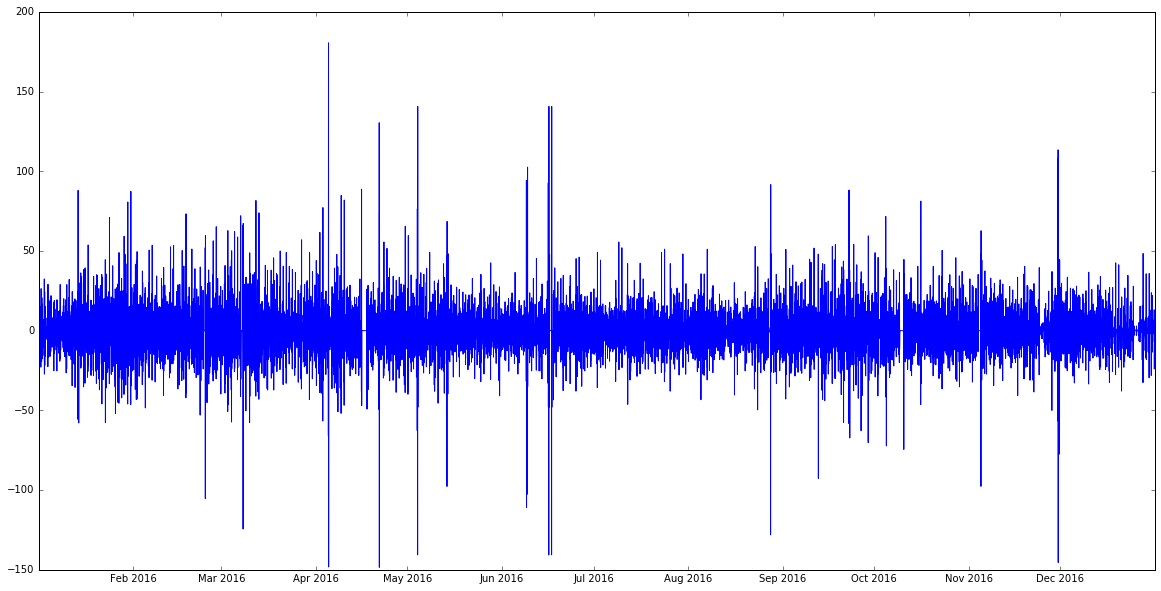

In [111]:
plt.figure(figsize=(20,10))
plt.plot(ts['y'])

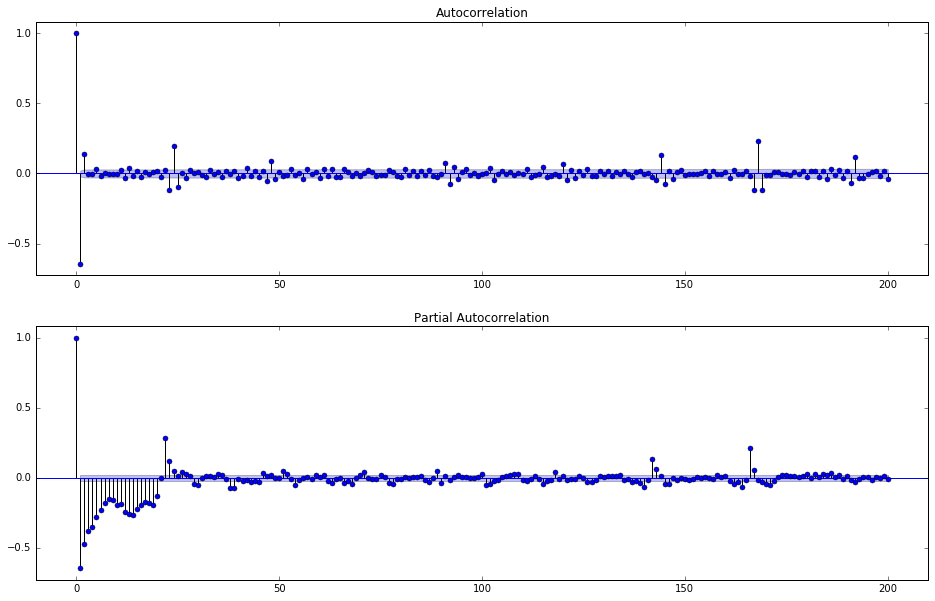

In [112]:
# Plotting ACF and PACF
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['y'],ax=ax1,lags=400)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['y'],ax=ax2,lags=400)

In [117]:
model = sm.tsa.ARIMA(ts['y'],order=(12,0,14)).fit()

/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [119]:
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8781
Model:                   ARMA(12, 14)   Log Likelihood              -28553.911
Method:                       css-mle   S.D. of innovations              6.244
Date:                Thu, 27 Apr 2017   AIC                          57163.822
Time:                        16:56:39   BIC                          57362.072
Sample:                    01-01-2016   HQIC                         57231.364
                         - 12-31-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.684e-05      0.001     -0.065      0.948      -0.002       0.002
ar.L1.y       -0.2238      0.015    -15.305      0.000      -0.252      -0.195
ar.L2.y        0.1390      0.005     25.339      0.0

In [121]:
model2 = sm.tsa.ARIMA(ts['y'],order=(9,0,12)).fit()
model2.aic

/Users/ishanchandel/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


57219.79751193238

In [122]:
print model2.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 8781
Model:                    ARMA(9, 12)   Log Likelihood              -28586.899
Method:                       css-mle   S.D. of innovations              6.270
Date:                Thu, 27 Apr 2017   AIC                          57219.798
Time:                        17:02:49   BIC                          57382.645
Sample:                    01-01-2016   HQIC                         57275.279
                         - 12-31-2016                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.167      0.867      -0.002       0.002
ar.L1.y       -0.4156        nan        nan        nan         nan         nan
ar.L2.y        0.2061        nan        nan        n